In [1]:
import sys
from pathlib import Path
sys.path.extend(['/'.join(str(Path.cwd()).split('/')[:4])])
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from classifiers.datasets import IrisDataset
from classifiers.quantum.qasvm import PseudoNormQSVM, NormQSVM
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit import BasicAer
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from classifiers.quantum.ansatz import Circuit15, Circuit9

In [3]:
ds = IrisDataset(feature_range=(-np.pi/2, np.pi/2))
X, y = ds.sample(n=64, return_X_y=True)

In [4]:
var_form = Circuit15(6, reps=5)
# feature_map = ZZFeatureMap(feature_dimension=2)
feature_map1 = Circuit9(4, reps=1)
feature_map = feature_map1.copy()
for _ in range(2 - 1):
    feature_map.compose(feature_map1, inplace=True)
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'), shots=2**15)
qasvm = PseudoNormQSVM(
    data=X, label=y,
    quantum_instance=quantum_instance,
    feature_map=feature_map,
    var_form=None
)

In [5]:
from tqdm.notebook import tqdm
storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**15, blocking=True, last_avg=16, callback=storage)
for epoch in tqdm(range(1, 2**15 + 1)):
    optimizer.step(qasvm.cost_fn, qasvm.parameters)
    
    if storage.num_accepted() > 2 * 16 and storage.last_cost_avg(2 * 16, ignore_rejected=True) < \
            storage.last_cost_avg(16, ignore_rejected=True):
        break
        

  0%|          | 0/32768 [00:00<?, ?it/s]

(0.0, 0.2)

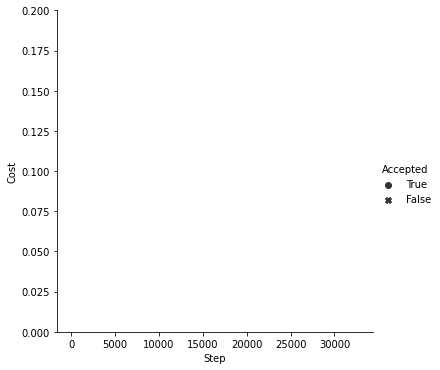

In [6]:
%matplotlib inline
storage.plot()
plt.ylim([0., .2])

In [7]:
qasvm.accuracy(X, y)

0.34375

In [8]:
from qiskit_machine_learning.kernels import QuantumKernel

qk = QuantumKernel(feature_map, enforce_psd=False, quantum_instance = quantum_instance)
def my_kernel(x, y):
    return (np.abs(qk.evaluate([x], [y]))**2).item()

from classifiers.convex.svm import BinarySVM
svm = BinarySVM(kernel=my_kernel, k=1, C=None, mutation='REDUCED_QASVM')
svm.fit(X, y)

In [9]:
svm.accuracy(X, y)

0.625

In [10]:
qasvm.accuracy(Xt, yt)

NameError: name 'Xt' is not defined

In [ ]:
svm.accuracy(Xt, yt)

In [ ]:
svm.result['dual objective']